# Forest Fires Analysis and Prediction

**Tujuan**: Memprediksi luas kebakaran hutan (`area`) dari dataset `forestfires.csv` menggunakan tiga model regresi:

- **Linear Regression**
- **Random Forest Regressor**
- **Support Vector Regressor (SVR)**

Notebook ini juga mencakup:
- EDA (Exploratory Data Analysis) dengan visualisasi
- Preprocessing (OneHot Encoding, Scaling)
- Hyperparameter Tuning
- Export hasil & model


## 1. Install & Import Library

In [1]:
# Install versi terbaru scikit-learn dan joblib
!pip install --upgrade scikit-learn joblib

import os
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Set random seed untuk reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Buat folder output jika belum ada
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


## 2. Load Dataset

In [2]:
CSV_PATH = "/content/forestfires.csv"
if not os.path.exists(CSV_PATH):
    from google.colab import files
    uploaded = files.upload()
    CSV_PATH = list(uploaded.keys())[0]

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head()

Shape: (517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## 3. Eksplorasi Awal & Statistik Ringkas

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### 3.1 Cek Missing Values & Nilai Unik

In [4]:
print("Missing values per column:")
print(df.isna().sum())

print("\nNilai unik kolom kategorikal:")
for c in ['month', 'day']:
    if c in df.columns:
        print(c, sorted(df[c].unique().tolist()))

Missing values per column:
X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

Nilai unik kolom kategorikal:
month ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']
day ['fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed']


## 4. Visualisasi EDA

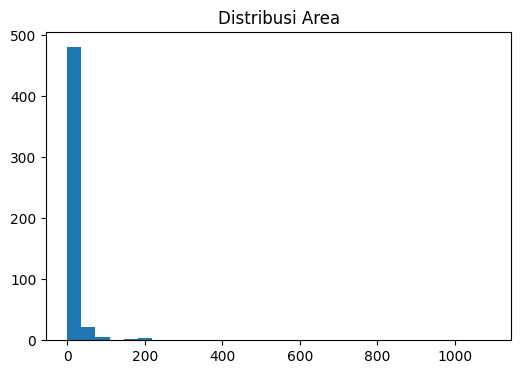

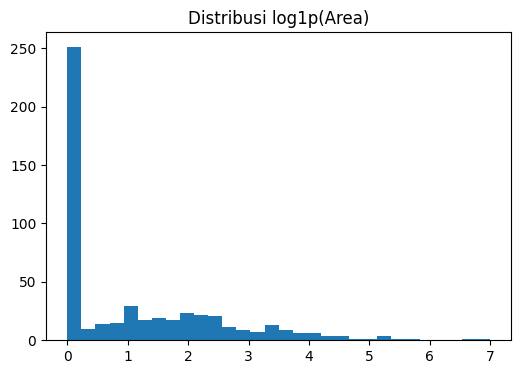

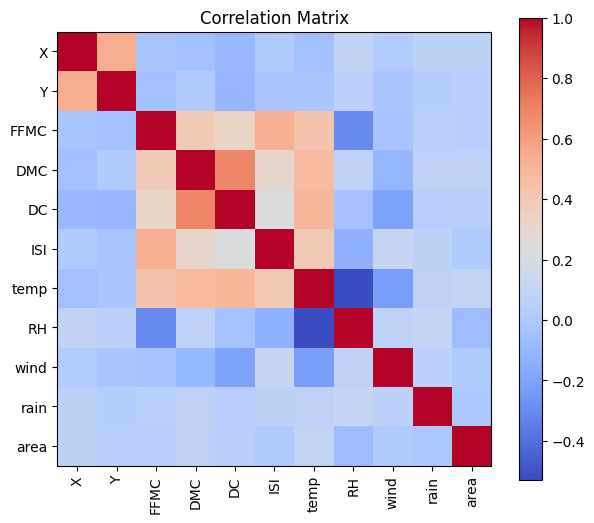

In [5]:
# Distribusi area
plt.figure(figsize=(6,4))
plt.hist(df['area'], bins=30)
plt.title('Distribusi Area')
plt.savefig(f"{OUTPUT_DIR}/hist_area_raw.png")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(np.log1p(df['area']), bins=30)
plt.title('Distribusi log1p(Area)')
plt.savefig(f"{OUTPUT_DIR}/hist_area_log1p.png")
plt.show()

# Korelasi numerik
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()
plt.figure(figsize=(7,6))
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation Matrix')
plt.savefig(f"{OUTPUT_DIR}/corr_numeric.png")
plt.show()

## 5. Preprocessing & Split Data

In [6]:
X = df.drop(columns=['area'])
y_raw = df['area'].values
y_log = np.log1p(y_raw)

categorical_cols = [c for c in X.columns if X[c].dtype == 'object']
numeric_cols = [c for c in X.columns if X[c].dtype != 'object']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

X_train, X_test, y_train_log, y_test_log, y_train_raw, y_test_raw = train_test_split(
    X, y_log, y_raw, test_size=0.2, random_state=RANDOM_STATE
)

### Fungsi Evaluasi

In [7]:
def evaluate(y_true_raw, y_pred_log, label):
    y_pred_raw = np.expm1(y_pred_log)
    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    rmse = math.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
    r2 = r2_score(y_true_raw, y_pred_raw)
    print(f"[{label}] MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.4f}")
    return {"Model": label, "MAE": mae, "RMSE": rmse, "R2": r2}

metrics = []

## 6. Model Training & Evaluasi

In [8]:
# Linear Regression
linreg = Pipeline([('pre', preprocessor), ('model', LinearRegression())])
linreg.fit(X_train, y_train_log)
pred_linreg = linreg.predict(X_test)
metrics.append(evaluate(y_test_raw, pred_linreg, 'LinearRegression'))

# Random Forest
rf = Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(n_estimators=300, random_state=RANDOM_STATE))])
rf.fit(X_train, y_train_log)
pred_rf = rf.predict(X_test)
metrics.append(evaluate(y_test_raw, pred_rf, 'RandomForest'))

# SVR
svr = Pipeline([('pre', preprocessor), ('scaler', StandardScaler(with_mean=False)), ('model', SVR(kernel='rbf', C=10, epsilon=0.1))])
svr.fit(X_train, y_train_log)
pred_svr = svr.predict(X_test)
metrics.append(evaluate(y_test_raw, pred_svr, 'SVR_RBF'))

[LinearRegression] MAE=20.11, RMSE=109.80, R2=-0.0227
[RandomForest] MAE=19.85, RMSE=109.97, R2=-0.0259
[SVR_RBF] MAE=19.79, RMSE=110.10, R2=-0.0284


## 7. Hyperparameter Tuning

In [9]:
# Random Forest Grid Search
rf_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [None, 10, 20]
}

rf_gs = GridSearchCV(
    Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(random_state=RANDOM_STATE))]),
    param_grid=rf_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1
)
rf_gs.fit(X_train, y_train_log)
print('Best RF Params:', rf_gs.best_params_)
pred_rf_gs = rf_gs.predict(X_test)
metrics.append(evaluate(y_test_raw, pred_rf_gs, 'RandomForest(GridSearch)'))

# SVR Grid Search
svr_grid = {
    'model__C': [1.0, 10.0, 50.0],
    'model__epsilon': [0.1, 0.2, 0.5],
    'model__gamma': ['scale', 'auto']
}

svr_gs = GridSearchCV(
    Pipeline([('pre', preprocessor), ('scaler', StandardScaler(with_mean=False)), ('model', SVR(kernel='rbf'))]),
    param_grid=svr_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1
)
svr_gs.fit(X_train, y_train_log)
print('Best SVR Params:', svr_gs.best_params_)
pred_svr_gs = svr_gs.predict(X_test)
metrics.append(evaluate(y_test_raw, pred_svr_gs, 'SVR(GridSearch)'))

Best RF Params: {'model__max_depth': 10, 'model__n_estimators': 400}
[RandomForest(GridSearch)] MAE=19.79, RMSE=109.94, R2=-0.0254
Best SVR Params: {'model__C': 10.0, 'model__epsilon': 0.5, 'model__gamma': 'scale'}
[SVR(GridSearch)] MAE=19.67, RMSE=110.11, R2=-0.0286


## 8. Simpan Hasil & Model

In [10]:
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(f"{OUTPUT_DIR}/metrics.csv", index=False)
metrics_df

best_label = metrics_df.sort_values(by='R2', ascending=False).iloc[0]['Model']
best_pipe = {
    'LinearRegression': linreg,
    'RandomForest': rf,
    'SVR_RBF': svr,
    'RandomForest(GridSearch)': rf_gs.best_estimator_,
    'SVR(GridSearch)': svr_gs.best_estimator_
}[best_label]

joblib.dump(best_pipe, f"{OUTPUT_DIR}/best_model.joblib")
print('Best model saved as best_model.joblib')

Best model saved as best_model.joblib
